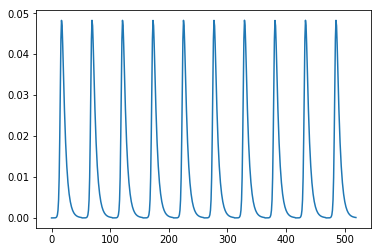

In [214]:
import scipy.integrate as spi
import numpy as np
import pylab as pl
from scipy.stats import truncnorm
import scipy.integrate as spi
import numpy as np
import pylab as pl
import matplotlib.pyplot as plt

def generate_data(x,beta,gamma):

    TS=1.0
    ND=70
    S0=1-1e-6
    I0=1e-6
    INPUT = (S0, I0, 0.0)


    def diff_eqs(INP,t):  
        '''The main set of equations'''
        Y=np.zeros((3))
        V = INP    
        Y[0] = - beta * V[0] * V[1]
        Y[1] = beta * V[0] * V[1] - gamma * V[1]
        Y[2] = gamma * V[1]
        return Y   # For odeint

    t_start = 0.0; t_end = ND; t_inc = TS
    t_range = np.arange(t_start, t_end+t_inc, t_inc)
    RES = spi.odeint(diff_eqs,INPUT,t_range)
    return RES[:,1] +  truncnorm.rvs(0, 100000, scale=.001, size=71)
#print (data)
#print (t_range)
count =0
data = []
with open ("/Users/gcgibson/Downloads/San_Juan_Training_Data.csv") as f:
        for line in f.readlines():
            if count > 0:
                data.append(line.replace("\n","").split(',')[-1])
            count +=1

data = []        
for i in range(10):
    tmp = simple_sir(range(52),1.1+np.random.normal(0,.0001),.2+np.random.normal(0,.0001))
    data.append(tmp.tolist())

#print (data)
   
data = np.array(data,dtype=np.float32).flatten()

data = data/np.max(data+10)
generated_data = data[:52]
plt.plot(data)
plt.show()

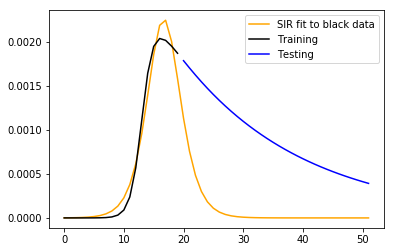

In [202]:
from scipy.optimize import curve_fit

def simple_sir(x,beta,gamma):
    #beta=1.4247
    #gamma=0.14286
    TS=1
    ND=51
    S0=1-1e-6
    I0=1e-6
    INPUT = (S0, I0, 0.0)


    def diff_eqs(INP,t):  
        '''The main set of equations'''
        Y=np.zeros((3))
        V = INP    
        Y[0] = - beta * V[0] * V[1]
        Y[1] = beta * V[0] * V[1] - gamma * V[1]
        Y[2] = gamma * V[1]
        return Y   # For odeint

    t_start = 0.0; t_end = ND; t_inc = TS
    t_range = np.arange(t_start, t_end+t_inc, t_inc)
    RES = spi.odeint(diff_eqs,INPUT,t_range)
    return RES[:,1][:len(x)]


def fit_sir_to_data(data):
    popt, pcov = curve_fit(simple_sir, range(len(data)), data)
    local_sampled_trajectories = simple_sir(range(52),popt[0],popt[1])
    return local_sampled_trajectories,popt
sample,_ = fit_sir_to_data(data[:20])
plt.plot(range(52),sample,color="orange")
plt.plot(range(20),data[:20],color="black")
plt.plot(range(20,52),data[20:52],color="blue")
plt.legend(("SIR fit to black data","Training","Testing"))
plt.show()

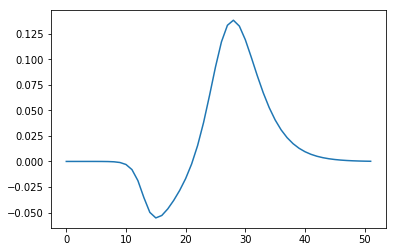

In [211]:

import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop

from keras.layers.core import Lambda
from keras import backend as K

from sklearn.metrics import mean_squared_error
batch_size =1
plt.plot(local_sampled_trajectories-generated_data)
plt.show()

In [212]:

def nn_no_sir(data):
    x_train = []
    y_train = []
    x_test = []
    y_test = []
    
    for i in range(0,52*4,52):
        sir_fit = fit_sir_to_data(data[i:i+52])
        x_train.append(sir_fit.tolist())
        y_train.append(data[i:i+52])
    
    x_train = np.array(x_train).flatten()
    y_train = np.array(y_train).flatten()
    plt.plot(x_train)
    plt.show()
    model = Sequential()
    model.add(Dense(4, activation='tanh', input_shape=(1,)))
    #model.add(Lambda(lambda x: K.dropout(x, level=0.001)))
    model.add(Dense(8, activation='tanh'))
    model.add(Dense(1, activation='linear'))


    model.compile(loss='mean_squared_error',
                  optimizer=RMSprop())

    history = model.fit(x_train, y_train,
                        batch_size=batch_size,
                        epochs=100,
                        verbose=0)

    return model


model_ = nn_no_sir(data)





AttributeError: 'tuple' object has no attribute 'tolist'

In [213]:
seasons = []
for i in range(0,52*10,52):
    seasons.append(data[i:(i+52)])
#def predict_sir():
betas = []
gammas = []

for season in seasons:
    _,popt = fit_sir_to_data(season)
    betas.append(popt[0])
    gammas.append(popt[1])
    
plt.plot(betas,color='blue')
plt.plot(gammas,color='green')

plt.show()

import pyflux

beta_model = pyflux.ARIMA(data=np.array(betas), ar=3, ma=0, family=pyflux.Normal())
beta_model.fit("MLE")
beta_pred = beta_model.predict(h=1).values[0]

gamma_model = pyflux.ARIMA(data=np.array(gammas), ar=3, ma=0, family=pyflux.Normal())
gamma_model.fit("MLE")
gamma_pred = gamma_model.predict(h=1).values[0]

print (beta_pred,gamma_pred)
plt.plot(simple_sir(range(52),beta_pred,gamma_pred))
plt.plot(data[52*10:52*11])
plt.show()


RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 600.

Starting forward filtering...
Forward fitering completed.
Starting forward filtering...
Forward fitering completed.
(69.7542646081674, 68.19795863219781)


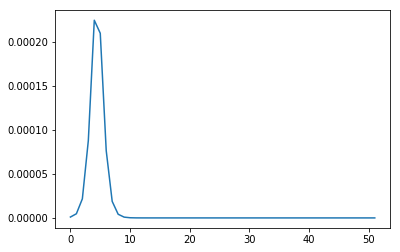

In [205]:
from pydlm import dlm, trend, seasonality, dynamic, autoReg, longSeason
myDLM = dlm(betas)
#myDLM = myDLM + trend(1, name='lineTrend', w=1.0)
myDLM = myDLM +autoReg(degree=1,data=betas, discount=0.99, name='ar3', w=1e7)

myDLM.fitForwardFilter()
beta_pred = myDLM.predictN(N=1)[0][0]


myDLM = dlm(gammas)
#myDLM = myDLM + trend(1, name='lineTrend', w=1.0)
myDLM = myDLM +autoReg(degree=1,data=betas ,discount=0.99, name='ar3', w=1e7)

myDLM.fitForwardFilter()
gamma_pred = myDLM.predictN(N=1)[0][0]




print (beta_pred,gamma_pred)
plt.plot(simple_sir(range(52),beta_pred,gamma_pred))
plt.plot(data[52*10:52*11])
plt.show()

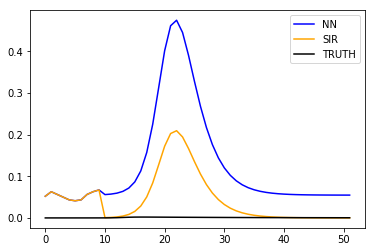

In [206]:

plt.plot(np.append(y_train,pred_),color="blue")
plt.plot(np.append(y_train,x_test),color="orange")
plt.plot(generated_data,color="black")
plt.legend(("NN","SIR","TRUTH"))
plt.show()